# Libs

In [1]:
#import Rede_Neural as rna
#from Rede_Neural import NeuralNetwork
#from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
#import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#from utils import plot

%matplotlib inline

ref.
- https://www.kaggle.com/competitions/pcs5022-decalearn-task1
- https://towardsdatascience.com/introduction-on-tensorflow-2-0-bd99eebcdad5 (excelente, veio do treinamento tensor flow da GCP, util no decalearn de imagem tb.)
- https://www.tensorflow.org/guide/tensor?hl=pt-br (documentação oficial)
- https://www.youtube.com/watch?v=5ECD8J3dvDQ (Introduction to TensorFlow 2.0: Easier for beginners, and more powerful for experts (TF World '19))

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2

from keras.utils import to_categorical
from keras.layers import Input
from tensorflow.keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from keras_tuner import HyperModel, BayesianOptimization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from kerastuner import HyperModel
from kerastuner.tuners import BayesianOptimization


from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pickle
import os



C:\Users\caio.azevedo\AppData\Local\Temp\ipykernel_14780\2420661091.py:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [4]:
# Ensure the directory exists or create it
output_dir = os.path.abspath('C:\\Caio\\decalearn\\task2')
os.makedirs(output_dir, exist_ok=True)

In [43]:
def remove_highly_correlated_columns(data, threshold=0.9):
    """
    Remove columns from a NumPy array where the correlation coefficient
    is greater than a specified threshold.

    Parameters:
    - data: np.ndarray, the input array.
    - threshold: float, the correlation coefficient threshold.

    Returns:
    - np.ndarray, the array with highly correlated columns removed.
    """
    if not isinstance(data, np.ndarray):
        raise ValueError("Input data must be a NumPy array.")
    
    corr_matrix = np.corrcoef(data, rowvar=False)
    to_remove = set()
    
    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[0]):
            if abs(corr_matrix[i, j]) > threshold:
                to_remove.add(j)

    columns_to_keep = [i for i in range(data.shape[1]) if i not in to_remove]
    filtered_data = data[:, columns_to_keep]

    return filtered_data


In [44]:
def reduce_dimensionality(data, variance_threshold=0.95):
    """
    Reduce the dimensionality of a NumPy array using PCA while retaining the specified variance.

    Parameters:
    - data: np.ndarray, the input array with shape (n_samples, n_features).
    - variance_threshold: float, the amount of variance to retain.

    Returns:
    - np.ndarray, the transformed array with reduced dimensions.
    """
    if not isinstance(data, np.ndarray):
        raise ValueError("Input data must be a NumPy array.")
    
    # Initialize PCA to retain the specified amount of variance
    pca = PCA(n_components=variance_threshold)
    
    # Fit the PCA model and transform the data
    reduced_data = pca.fit_transform(data)
    
    return reduced_data

In [45]:
# Function to find the best threshold
def find_best_threshold(y_true, y_pred_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # Avoid division by zero
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    return best_threshold

In [46]:
# Make predictions on validation data
def check_result(dataset_X_test, dataset_y_test, NN):
    
    y_test_probs = NN.predict(dataset_X_test).ravel()
    
    print('Acurácia default: {:.2f}%'.format(100*accuracy_score(dataset_y_test, y_test_probs > 0.5)))
    
    # Find the best threshold on validation data
    #best_threshold = find_best_threshold(dataset_y_test, y_test_probs)
    best_threshold = find_best_threshold_for_accuracy(dataset_y_test, y_test_probs)
    print(f"Best Threshold: {best_threshold}")

    # Apply the best threshold to make binary predictions
    y_test_pred = (y_test_probs > best_threshold).astype(int)
    print('Acurácia best threshold: {:.2f}%'.format(100*accuracy_score(dataset_y_test, y_test_pred)))

    # Print the predictions
    #print("Predicted probabilities:\n", y_test_probs)
    #print("Predicted classes:\n", y_test_pred)
    #print("True classes:\n", y_test)

In [47]:
class PlotTrainingHistory(Callback):
  def on_train_begin(self, logs={}):
    self.losses = []
    self.val_losses = []
    self.accuracies = []
    self.val_accuracies = []
  
  def on_epoch_end(self, epoch, logs={}):
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.accuracies.append(logs.get('accuracy'))
    self.val_accuracies.append(logs.get('val_accuracy'))

  def plot_history(self):
    plt.plot(self.losses, label='Train Loss')
    plt.plot(self.val_losses, label='Val Loss')
    plt.plot(self.accuracies, label='Train Accuracy')
    plt.plot(self.val_accuracies, label='Val Accuracy')
    plt.title('Model Loss and Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define and compile your Keras model (replace with your model code)

# Create the callback object
plot_history = PlotTrainingHistory()


# Loading Data

In [48]:
# Carrega a base de dados a partir de seu caminho
data = np.load('data/dataset.npz')
print(data.files)

['X_train', 'y_train', 'X_test', 'y_test']


In [49]:
XX_train = data['X_train']
yy_train = data['y_train']
yy_train = yy_train.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
X = XX_train
y = yy_train

unseen_data = data['X_test']
print('features: ', unseen_data.shape)

features:  (385, 26000)


In [50]:
df = pd.DataFrame(X)
df['target'] = y
#df.to_csv('dataset.csv')

# DataPrep

In [51]:
def dataprep_full(dataset, target, split = True):
    X_train, X_test, y_train, y_test = None, None, None, None
    
    pearson_threshold = 0.9
    # Create a pipeline for standardization and PCA
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95))
    ])

    dataset = remove_highly_correlated_columns(dataset, pearson_threshold)
    print('features n-correlacionadas: ', dataset.shape)

    if split:
        seed = 7
        test_size = 0.2
        X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=test_size, random_state=seed)
        
        # Transform the features
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.transform(X_test)
        #print(X_train.min(axis=0), X_train.max(axis=0))
    else:
        dataset  = pipeline.fit_transform(dataset)

    return dataset, X_train, X_test, y_train, y_test


In [52]:
def dataprep_standardScaler(dataset, target, split = True):
    X_train, X_test, y_train, y_test = None, None, None, None
    
    pearson_threshold = 0.9
    # Create a pipeline for standardization and PCA
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        #('pca', PCA(n_components=0.95))
    ])

    dataset = remove_highly_correlated_columns(dataset, pearson_threshold)
    print('features n-correlacionadas: ', dataset.shape)

    if split:
        seed = 7
        test_size = 0.2
        X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=test_size, random_state=seed)
        
        # Transform the features
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.transform(X_test)
        #print(X_train.min(axis=0), X_train.max(axis=0))
    else:
        dataset  = pipeline.fit_transform(dataset)

    return dataset, X_train, X_test, y_train, y_test

In [53]:
def dataprep_pearson(dataset, target, split = True):
    X_train, X_test, y_train, y_test = None, None, None, None
    
    pearson_threshold = 0.9
    dataset = remove_highly_correlated_columns(dataset, pearson_threshold)
    print('features n-correlacionadas: ', dataset.shape)

    if split:
        seed = 7
        test_size = 0.2
        X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=test_size, random_state=seed)
    
    return dataset, X_train, X_test, y_train, y_test

In [54]:
def dataprep_split(dataset, target, split = True):
    X_train, X_test, y_train, y_test = None, None, None, None

    if split:
        seed = 7
        test_size = 0.2
        X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=test_size, random_state=seed)
    
    return dataset, X_train, X_test, y_train, y_test

In [55]:
#matriz de correlação
#corr = df.corr()
#corr = corr.style.background_gradient(cmap='Blues')
#corr

In [56]:

#X, X_train, X_test, y_train, y_test = dataprep_split(X, y, split = True)
#X, X_train, X_test, y_train, y_test = dataprep_pearson(X, y, split = True)
#X, X_train, X_test, y_train, y_test = dataprep_standardScaler(X, y, split = True)
X, X_train, X_test, y_train, y_test = dataprep_full(X, y, split = True)

print('features train: ', X_train.shape)
print('features test: ', X_test.shape)
print('target trainning dimensions: ', y_train.shape)
print('target testing dimensions: ', y_test.shape)

features n-correlacionadas:  (1428, 481)
features train:  (1142, 157)
features test:  (286, 157)
target trainning dimensions:  (1142, 1)
target testing dimensions:  (286, 1)


In [57]:
unique_values, indices, counts = np.unique(y_train, return_index=True, return_counts=True)

print("Unique values:", unique_values)
print("Indices:", indices)
print("Counts:", counts)
#print("Proportion:", counts[0]/counts[1])

Unique values: [0 1 2 3 4]
Indices: [ 0  4  5  1 14]
Counts: [257 292 195 254 144]


In [58]:
df = pd.DataFrame(X_train)
df['target'] = y_train
df.to_csv('dataset.csv')

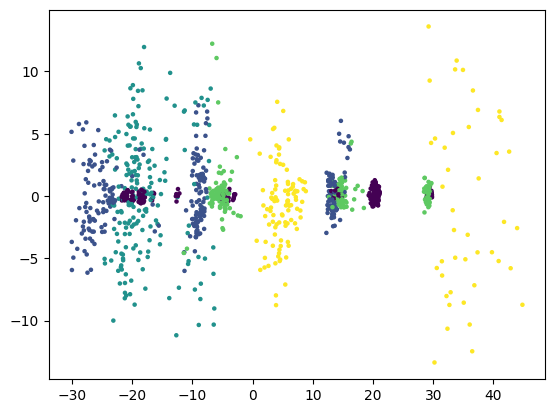

In [59]:
plt.scatter(X_train[:,0], X_train[:,1], c=list(np.array(y_train).ravel()), s=5, cmap='viridis')

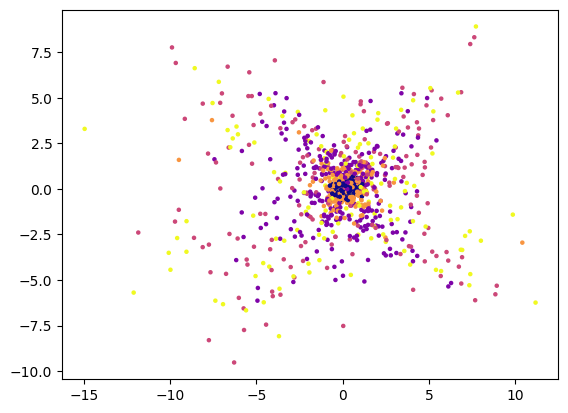

In [60]:
plt.scatter(X_train[:,2], X_train[:,3], c=list(np.array(y_train).ravel()), s=5, cmap='plasma')

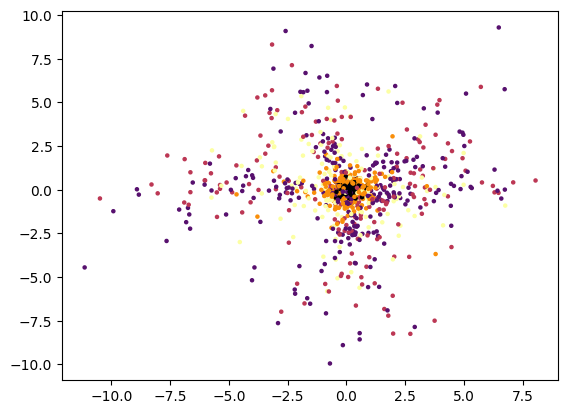

In [61]:
plt.scatter(X_train[:,4], X_train[:,5], c=list(np.array(y_train).ravel()), s=5, cmap='inferno')

In [62]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]
print(input_dim, output_dim)

157 1


# NN Configuration

Key Changes:
Increased Units and Layers: I increased the maximum number of units and allowed up to 5 hidden layers.
Regularization: Added L2 regularization and dropout layers to each dense layer to reduce overfitting.
Activation Functions: Added 'tanh' as an additional activation function choice.
Advanced Optimizers: Included 'sgd' and 'rmsprop' optimizers as choices.
Tuning Range: Increased the range for some hyperparameters to explore more configurations.
Max Trials: Increased max_trials to 50 for a more exhaustive search of hyperparameters.

To enhance the performance of your neural network for multi-class classification, several strategies can be employed. Below, I'll propose some changes and additions to your existing configuration, considering the complexity and dimensionality of your input features. These modifications aim to increase the accuracy of your model:

Layer Complexity: Add more layers with different configurations to capture more complex patterns.
Regularization: Incorporate dropout and L2 regularization to prevent overfitting.
Advanced Optimizers: Experiment with different optimizers and learning rates.
Learning Rate Schedulers: Implement learning rate schedules for better convergence.
Feature Engineering: Apply techniques like Principal Component Analysis (PCA) for dimensionality reduction if feasible.

In [63]:
class MyHyperModel(HyperModel):
    
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def build(self, hp):
        initializer = tf.keras.initializers.GlorotNormal(seed=12227)

        inputs = Input(shape=(input_dim,))
        H = Dense(
            units=hp.Int('units_1', min_value=64, max_value=1024, step=64),
            activation=hp.Choice('activation_1', values=['relu', 'swish', 'tanh']),
            kernel_initializer=initializer,
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_1', min_value=1e-5, max_value=1e-2, sampling='LOG'))
        )(inputs)
        H = BatchNormalization()(H)
        H = Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1))(H)
        
        for i in range(hp.Int('num_layers', 1, 5)):
            H = Dense(
                units=hp.Int(f'units_{i+2}', min_value=64, max_value=1024, step=64),
                activation=hp.Choice(f'activation_{i+2}', values=['relu', 'swish', 'tanh']),
                kernel_initializer=initializer,
                kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'l2_{i+2}', min_value=1e-5, max_value=1e-2, sampling='LOG'))
            )(H)
            H = BatchNormalization()(H)
            H = Dropout(rate=hp.Float(f'dropout_{i+2}', min_value=0.1, max_value=0.5, step=0.1))(H)

        outputs = Dense(self.num_classes, activation='softmax', kernel_initializer=initializer)(H)
        model = Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
            loss=CategoricalCrossentropy(),
            metrics=[CategoricalAccuracy()]
        )
        
        return model

In [64]:
# Number of classes in your dataset
num_classes = 5  # replace with your actual number of classes
hypermodel = MyHyperModel(num_classes=num_classes)

In [65]:
# Instantiate the tuner
tuner = BayesianOptimization(
    hypermodel,
    objective='val_categorical_accuracy',
    max_trials=50,
    executions_per_trial=3,
    directory='output_dir',
    project_name='hyperparam_tuning_numeric',
    overwrite=True  # Overwrite the previous results
    )   

# Display the search space summary
tuner.search_space_summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(output_dir, 'best_model.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)
# Assuming you will add these callbacks to your tuner.search or model.fit call later

Search space summary
Default search space size: 10
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'swish', 'tanh'], 'ordered': False}
l2_1 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'swish', 'tanh'], 'ordered': False}
l2_2 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 

# Train, Test, Predict

In [66]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [67]:
def find_best_threshold(y_true, y_pred_probs):
    """
    Compute the best threshold for each class in multi-class classification to maximize F1-score.
    
    Args:
    y_true (numpy array): True labels (one-hot encoded).
    y_probs (numpy array): Predicted probabilities from the model.

    Returns:
    dict: A dictionary containing the best threshold for each class.
    """
    num_classes = y_true.shape[1]
    thresholds = {}

    for i in range(num_classes):
        precision, recall, threshold = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        best_threshold_index = np.argmax(f1_scores)
        best_threshold = threshold[best_threshold_index]
        thresholds[i] = best_threshold

    return thresholds

In [77]:
def find_best_threshold_for_accuracy(y_true, y_pred_probs):
    """
    Compute the best threshold for each class in multi-class classification to maximize accuracy.
    
    Args:
    y_true (numpy array): True labels (one-hot encoded).
    y_probs (numpy array): Predicted probabilities from the model.

    Returns:
    dict: A dictionary containing the best threshold for each class.
    """
    num_classes = y_true.shape[1]
    thresholds = {}

    for i in range(num_classes):
        best_threshold = 0.0
        best_accuracy = 0.0

        # Check thresholds from 0 to 1 with a step of 0.01
        for threshold in np.arange(0.0, 1.01, 0.01):
            y_pred = (y_pred_probs[:, i] >= threshold).astype(int)
            accuracy = accuracy_score(y_true[:, i], y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold

        thresholds[i] = best_threshold

    return thresholds

In [69]:
def apply_thresholds(y_probs, thresholds):
    """
    Apply the computed thresholds to the predicted probabilities to get the final class predictions.
    
    Args:
    y_probs (numpy array): Predicted probabilities from the model.
    thresholds (dict): Dictionary containing the best threshold for each class.

    Returns:
    numpy array: Final class predictions.
    """
    num_samples = y_probs.shape[0]
    num_classes = y_probs.shape[1]
    
    # Initialize the prediction array
    y_pred = np.zeros((num_samples, num_classes))
    
    for i in range(num_classes):
        # Apply the threshold for each class
        y_pred[:, i] = y_probs[:, i] >= thresholds[i]
    
    # Convert the binary predictions to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    return y_pred_labels

In [70]:
def train_model(X_train, y_train, X_val, y_val):
    # Start the hyperparameter search
    tuner.search(
        x=X_train,  # Replace with your training data
        y=y_train,  # Replace with your training labels
        epochs=50, #50 (melhor)
        validation_data=(X_test, y_test),  # Replace with your validation data
        batch_size=64,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=2
    ) 

In [79]:
def validate_model(X_val, y_val):
    # Once you find promising hyperparameters, you can refine the tuning on the full dataset
    
    #best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    #model = hypermodel.build(best_hps)
    #model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])
    #model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
    
    #y_pred = model.predict(X_val)

    #OUUUU
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.summary()
    # Evaluate the best model
    y_pred = best_model.predict(X_val)
    y_pred = y_pred.ravel()
    
    
    # Example usage:
    # y_true = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1], ...])  # True labels in one-hot encoded format
    # y_pred = model.predict(X_test)  # Predicted probabilities from the model
    # best_thresholds = compute_best_thresholds(y_true, y_pred)
    # print(best_thresholds)
    
    
    best_thresholds = find_best_threshold(y_true=y_val, y_pred_probs=y_pred)
    print(f"Best Threshold: {best_threshold}")

    # Apply the best threshold to make binary predictions
    # Example usage:
    # y_pred = model.predict(X_test)  # Predicted probabilities from the model
    # best_thresholds = compute_best_thresholds(y_true, y_pred)
    y_pred_labels = apply_thresholds(y_probs=y_pred, thresholds=best_thresholds)
    print(y_pred_labels)
    
    
    
    from sklearn.metrics import accuracy_score, classification_report

    accuracy = accuracy_score(np.argmax(y_val, axis=1), y_pred_labels)
    print(f'Accuracy: {accuracy}')
    print(classification_report(np.argmax(y_val, axis=1), y_pred_labels))
    
    
    
    y_test_pred = (y_pred > best_threshold).astype(int)
    print('Acurácia best threshold: {:.2f}%'.format(100*accuracy_score(y_val, y_test_pred)))
    
    threshold_default = 0.5
    y_test_pred = (y_pred > threshold_default).astype(int)
    print('Acurácia default threshold: {:.2f}%'.format(100*accuracy_score(y_val, y_test_pred)))
    
    
    #acc = accuracy_score(np.round(y_val), np.round(y_pred))
    #print('Validation accuracy: {:.2f}%'.format(acc * 100))
    return best_threshold

In [72]:
def print_training_metrics(X_val, y_val):
    # Assuming best_model is retrieved from the tuner
    best_model = tuner.get_best_models(num_models=1)[0]

    # Train the best model again to get the history
    history = best_model.fit(
        X_train,  # Your training data
        y_train,  # One-hot encoded training labels
        epochs=50,
        validation_data=(X_test, y_test),  # One-hot encoded validation data
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=2
    )

    # Plotting training & validation loss values
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plotting training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.show()

In [73]:
#train_model(X_train=X_train, y_train=y_train, X_val= X_test, y_val= y_test)

Trial 50 Complete [00h 00m 34s]
val_categorical_accuracy: 0.750582734743754

Best val_categorical_accuracy So Far: 0.8624708652496338
Total elapsed time: 00h 39m 50s


In [80]:
best_threshold = validate_model(X_val=X_test, y_val=y_test)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 157)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       161,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 832)            │       852,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 832)            │         3,328 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 704)            │       586,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 704)            │         2,816 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       180,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,794,053 (6.84 MB)

 Trainable params: 1,788,421 (6.82 MB)

 Non-trainable params: 5,632 (22.00 KB)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Epoch 1/50
36/36 - 4s - 112ms/step - categorical_accuracy: 0.8722 - loss: 0.9419 - val_categorical_accuracy: 0.7622 - val_loss: 1.4764 - learning_rate: 0.0010
Epoch 2/50
36/36 - 1s - 15ms/step - categorical_accuracy: 0.8616 - loss: 0.9844 - val_categorical_accuracy: 0.8077 - val_loss: 1.5085 - learning_rate: 0.0010
Epoch 3/50
36/36 - 1s - 15ms/step - categorical_accuracy: 0.9028 - loss: 0.8271 - val_categorical_accuracy: 0.7168 - val_loss: 1.8078 - learning_rate: 0.0010
Epoch 4/50
36/36 - 1s - 19ms/step - categorical_accuracy: 0.8967 - loss: 0.7957 - val_categorical_accuracy: 0.8287 - val_loss: 1.0548 - learning_rate: 0.0010
Epoch 5/50
36/36 - 1s - 15ms/step - categorical_accuracy: 0.9037 - loss: 0.8326 - val_categorical_accuracy: 0.7762 - val_loss: 1.5380 - learning_rate: 0.0010
Epoch 6/50
36/36 - 1s - 15ms/step - categorical_accuracy: 0.9142 - loss: 0.8031 - val_categorical_accuracy: 0.8007 - val_loss: 1.3105 - learning_rate: 0.0010
Epoch 7/50
36/36 - 1s - 15ms/step - categorical_acc

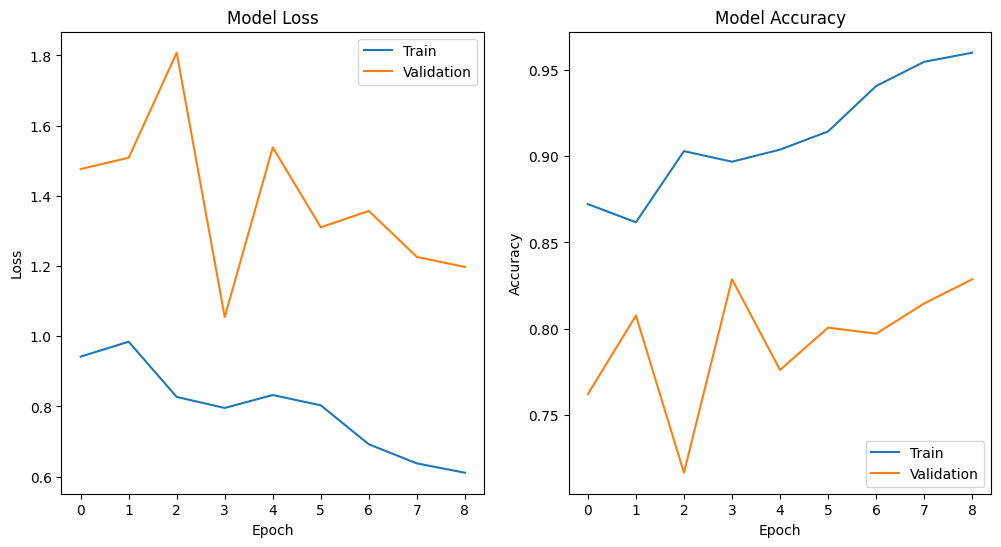

In [ ]:
print_training_metrics(X_val=X_test, y_val=y_test)